In [1]:
! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-10-01 20:26:54--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
CA-Zertifikat »/etc/ssl/certs/ca-certificates.crt« wurde geladen
Auflösen des Hostnamens raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Verbindungsaufbau zu raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 298573 (292K) [text/plain]
Wird in »laptops.csv« gespeichert.

laptops.csv         100%[===================>] 291,58K   413KB/s    in 0,7s    

2024-10-01 20:26:56 (413 KB/s) - »laptops.csv« gespeichert [298573/298573]



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('laptops.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Laptop        2160 non-null   object 
 1   Status        2160 non-null   object 
 2   Brand         2160 non-null   object 
 3   Model         2160 non-null   object 
 4   CPU           2160 non-null   object 
 5   RAM           2160 non-null   int64  
 6   Storage       2160 non-null   int64  
 7   Storage type  2118 non-null   object 
 8   GPU           789 non-null    object 
 9   Screen        2156 non-null   float64
 10  Touch         2160 non-null   object 
 11  Final Price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   laptop        2160 non-null   object 
 1   status        2160 non-null   object 
 2   brand         2160 non-null   object 
 3   model         2160 non-null   object 
 4   cpu           2160 non-null   object 
 5   ram           2160 non-null   int64  
 6   storage       2160 non-null   int64  
 7   storage_type  2118 non-null   object 
 8   gpu           789 non-null    object 
 9   screen        2156 non-null   float64
 10  touch         2160 non-null   object 
 11  final_price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


In [5]:
df = df[['ram', 'storage', 'screen', 'final_price']]

<Axes: xlabel='final_price', ylabel='Count'>

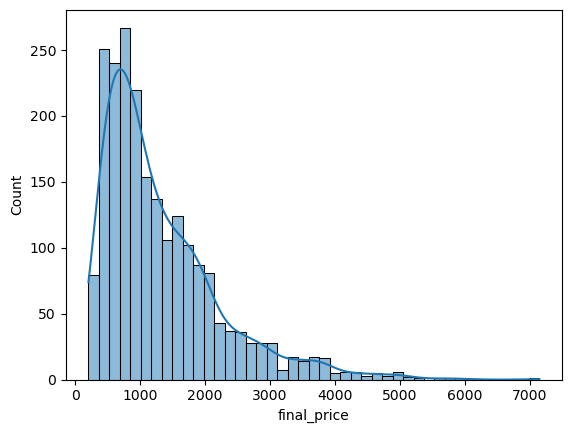

In [6]:
sns.histplot(data=df, x='final_price', kde=True)
# skewed data with a long right tail

# Q1

There's one column with missing values. What is it?

In [7]:
df.isna().any(axis=0) # screen

ram            False
storage        False
screen          True
final_price    False
dtype: bool

<Axes: xlabel='screen', ylabel='Count'>

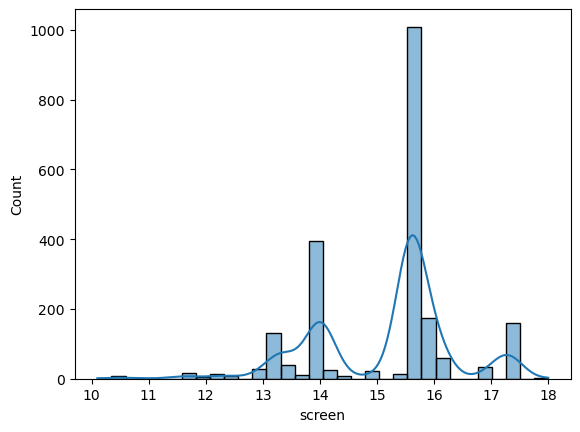

In [8]:
sns.histplot(data=df, x='screen', kde=True)

# Q2

What's the median (50% percentile) for variable 'ram'?

In [9]:
df['ram'].median()

np.float64(16.0)

# Split

In [10]:
def train_val_test_split(df, val_size=0.2, test_size=0.2, seed=42):
    # https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/chapter-02-car-price/02-carprice.ipynb
    n = len(df)
    n_val = int(val_size * n)
    n_test = int(test_size * n)
    n_train = n - (n_val + n_test)
    
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    df_shuffled = df.iloc[idx]
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    return df_train, df_val, df_test

df_train, df_val, df_test = train_val_test_split(df)
df_train.head()

,ram,storage,screen,final_price
2079,32,1000,15.6,1123.29
668,4,64,14.1,201.05
2073,32,1000,14.0,997.74
1113,16,512,13.3,1016.00
788,32,1000,16.0,2739.00


# Linear Regression

In [11]:
features=['ram', 'storage', 'screen']
from sklearn.metrics import root_mean_squared_error

def train_linear_regression_reg(X, y, r):
    # https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/chapter-02-car-price/02-carprice.ipynb
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def predict_linear_regression(X, w_0, w):
    return w_0 + X.dot(w)

def rmse(y_true, y_pred, num_digits):
    score = root_mean_squared_error(y_true, y_pred)
    return round(score, num_digits)

def evaluate_linear_regression(df_train, df_test,
                               r=0.0, num_digits=2):
    X_train = df_train[features].values
    y_train = df_train['final_price'].values
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    
    X_test = df_test[features].values
    y_true = df_test['final_price'].values
    y_pred = predict_linear_regression(X_test, w_0, w)
    return rmse(y_true, y_pred, num_digits=num_digits)

# Q3

## Impute screen with 0

In [12]:
df_train, df_val, df_test = train_val_test_split(df, seed=42)
df_train = df_train.fillna(0.0)
df_val = df_val.fillna(0.0)
evaluate_linear_regression(df_train, df_val, r=0.0, num_digits=2)

np.float64(597.36)

## Impute screen with mean

In [13]:
df_train, df_val, df_test = train_val_test_split(df, seed=42)
screen_mean = df_train['screen'].mean()
df_train['screen'] = df_train['screen'].fillna(screen_mean)
df_val['screen'] = df_val['screen'].fillna(screen_mean)
evaluate_linear_regression(df_train, df_val, r=0.0, num_digits=2)

np.float64(600.27)

# Q4

In [14]:
df_train, df_val, df_test = train_val_test_split(df, seed=42)
df_train = df_train.fillna(0.0)
df_val = df_val.fillna(0.0)

r_candidates = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_for_r = [evaluate_linear_regression(df_train, df_val, r=r, num_digits=2) for r in r_candidates]
pd.DataFrame(data=dict(r=r_candidates,rmse=rmse_for_r)) # actually 5 is the smallest

,r,rmse
0,0.00,597.36
1,0.01,597.36
2,0.10,597.35
3,1.00,597.21
4,5.00,597.01
5,10.00,597.06
6,100.00,597.90


Text(0, 0.5, 'RMSE')

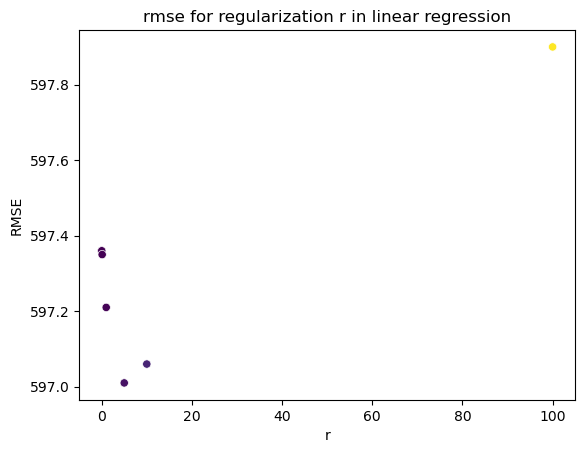

In [15]:
sns.scatterplot(x=r_candidates, y=rmse_for_r, c=r_candidates)
plt.title("rmse for regularization r in linear regression")
plt.xlabel("r")
plt.ylabel("RMSE")

# Q5

In [16]:
def evaluate_seed(df, seed):
    df_train, df_val, df_test = train_val_test_split(df, seed=seed)
    df_train = df_train.fillna(0.0)
    df_val = df_val.fillna(0.0)
    return evaluate_linear_regression(df_train, df_val, r=0.0, num_digits=3)

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_for_seed = [evaluate_seed(df, seed) for seed in seeds]
pd.DataFrame(data=dict(seed=seeds,rmse=rmse_for_seed)) # actually 5 is the smallest

,seed,rmse
0,0,565.452
1,1,636.799
2,2,588.956
3,3,597.815
4,4,571.963
5,5,573.238
6,6,647.344
7,7,550.440
8,8,587.334
9,9,576.102


In [17]:
std = np.std(rmse_for_seed)
std

np.float64(29.176576478572677)

# Q6

In [18]:
df_train, df_val, df_test = train_val_test_split(df, seed=9)
df_train = pd.concat([df_train, df_val], axis=0)
df_train = df_train.fillna(0.0)
df_test = df_test.fillna(0.0)

evaluate_linear_regression(df_train, df_test, r=0.001, num_digits=2)

np.float64(608.61)